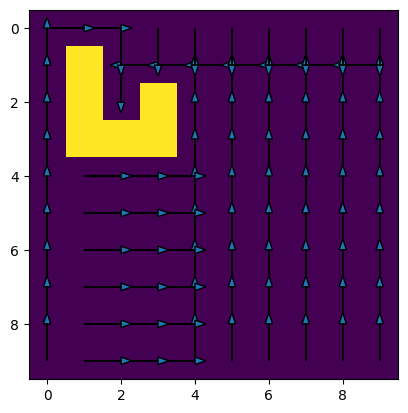

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

H = np.zeros([100,100])

# H[10:80,10:20] = 1
# H[40:48,30:75] = 1
# H[0:40, 50:52] = 1
# H[75: 85, 50: 100] = 1

H = np.zeros([10,10])
H[1: 4,1] = 1
H[3,1:4] = 1
H[2:4,3] = 1
# plt.imshow(H, interpolation='none')
# plt.show()
def generate_flow_field(grid, start):
    frontier = []
    frontier.append(start)
    came_from = dict()
    came_from[start] = None
    directions = [(0,1),(1,0),(0,-1),(-1,0)]
    while len(frontier) > 0:
        current = frontier.pop(0)
        for direction in directions:
            nextval = (direction[0] + current[0], direction[1] + current[1])
            if nextval[0] >= 0 and nextval[0] < len(grid) and nextval[1] >= 0 and nextval[1] < len(grid[0]) and nextval not in came_from and grid[current] == 0 and grid[nextval] == 0:   
                frontier.append(nextval)
                came_from[nextval] = current
    
    return came_from
came_from = generate_flow_field(H,(2,2))
for key in came_from:
    point = came_from[key]
    if point:
        plt.arrow(key[1],key[0],point[1]-key[1],point[0]-key[0],head_width = 0.2)
plt.imshow(H, interpolation='none')
plt.show()

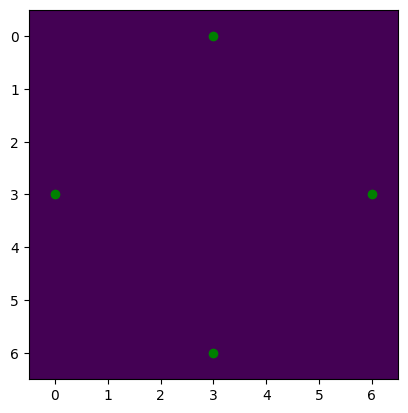

In [2]:
grid = np.zeros([7,7])

agents = set()
agents.add((3,0))
agents.add((0,3))

goals = set()
agents.add((3,6,0))
agents.add((6,3,1))
plt.imshow(grid, interpolation='none')
for agent in agents:
    plt.plot(agent[0],agent[1], '-go')

for goal in goals:
    plt.plot(goal[0],goal[1], '-go')
plt.show()

In [5]:
from queue import PriorityQueue
from dataclasses import dataclass, field
from typing import Any

# Prio queue compare prio only
@dataclass(order=True) 
class PrioritizedItem:
    priority: int
    item: Any=field(compare=False)

# 3D hash table ReservationTable to keep track of Agent state
class ReservationTable:
    def __init__(self):
        self.table = {}

    def reserve(self, x, y, time, agent_id):
        self.table[(x, y, time)] = agent_id
    
    def is_reserved(self, x, y, time):
        return (x, y, time) in self.table
    
# The agent start & goal positions in 2d space
class Agent:
    def __init__(self, id, start, goal):
        self.id = id
        self.start = start
        self.goal = goal

class Position:
    def __init__(self, x ,y):
        self.x = x
        self.y = y
    
    # Equality operator (==) overide comparison between position objects 
    def __eq__(self, other):
        return self.x == other.x and self.y == other.y

# Available actions 
# Movement 
class Action:
    MOVE_UP = (0, 1)
    MOVE_RIGHT = (1, 0)
    MOVE_LEFT = (-1, 0)
    MOVE_DOWN = (0, -1)
    WAIT = (0, 0)

    @classmethod
    def get_actions(cls):
        return [cls.MOVE_UP, cls.MOVE_DOWN, cls.MOVE_LEFT, cls.MOVE_RIGHT, cls.WAIT]


# Node object to keep track of visited cells to be reconstructed later
class Node:
    def __init__(self, priority, position, time, cost, parent=None):
        priority = priority
        self.x = position.x
        self.y = position.y
        self.time = time
        self.cost = cost
        self.parent = parent #Node pointer to parent node

    def calculate_f_cost(self):
        self.f_cost = self.g_cost + self.h_cost


def reconstruct_path(node):
    path = []
    current = node
    while current:
        path.append((Position(current.x, current.y), current.time))
        current = current.parent
    return list(reversed(path))

# Manhattan distance heuristic
def manhattan_distance(pos1, pos2):
    return abs(pos1.x - pos2.x) + abs(pos1.y - pos2.y)

# TODO: Implimented this heuristic function
# Source - https://github.com/balzer82/3D-OccupancyGrid-Python/blob/master/3D-AStar-PathPlanning.ipynb
# Heuristic berechnen
# def calcheuristic(grid,goal):

#     for z in range(zdim):
#         for y in range(ydim):
#             for x in range(xdim):
                 
#                 # Euklidische Distanz für jede Zelle zum Ziel berechnen
#                 dist=((x-goal[0])**2+(y-goal[1])**2+(z-goal[2])**2)**(1/2.0)
            
#                 # Höhe
#                 zheu = -6.0*float(z)
                
#                 # Horizontale von Soll
#                 yheu = np.abs(float(y) - goal[1])
                
#                 # und Höhe und Abweichung von y=0
#                 heuristic[x,y,z]= dist + yheu #+ zheu
#     '''     
#     for i in range(len(heuristic)):
#         print(heuristic[i])
#     '''
#     return heuristic

In [9]:
# TODO: Impliment robot state standstill to fill future reservation slots
# Source- https://www.davidsilver.uk/wp-content/uploads/2020/03/coop-path-AIIDE.pdf
# Cooperative A* - A decoupled approach with each agent's path calculated one at a time
# Each path's route passed into a 3D hash table containing a route's position 
# & at what time <X,Y,time>. Entries in the table are considered impassable by subsequent
# agent searches.
                                     
def cooperative_astar(agent_list, grid):
    print("In CA* \n")
    reservationTable = ReservationTable()
    paths = {}
    

    # class Agent:
    #   def __init__(self, id, start, goal):
    #     self.id = id
    #     self.start = start
    #     self.goal = goal
    for agent in agent_list:
        print("Agent ID [" + str(agent.id) + "]\n")
        start = agent.start
        goal = agent.goal
        openlist = PriorityQueue(maxsize = 0)
        closedlist = set()

        # --Node members--
        # priority = priority
        # self.x = position.x
        # self.y = position.y
        # self.time = time
        # self.cost = cost
        # self.parent = parent

        # Initial node
        start_node = Node(
            priority = 0,
            position = start,
            time = 0,
            cost = 0
        )
        # Wrap the start node in PrioritizedItem
        openlist.put(PrioritizedItem(priority=0, item=start_node))

        # Node initializer
        node_count = 0
        while not openlist.empty():
            #Current type - Node item
            current_item = openlist.get()
            current = current_item.item

            node_count += 1

            print("t= " + str(current.time) + " | Current Node #: " + str(node_count) + " at [" + str(current.x) + " , " + str(current.y) 
                  + "] - Cost: " + str(current.cost))

            #print(current)


            # Reconstruct path and store after path calculation
            if Position(current.x, current.y) == goal:
                paths[agent] = reconstruct_path(current)
                for pos, time in paths[agent]:
                    reservationTable.reserve(pos.x, pos.y, time, agent.id)
                break
            
            # Skip if already visited
            current_pos = (current.x, current.y, current.time)
            if current_pos in closedlist:
                continue
            # And add to closed list if not
            closedlist.add(current_pos)

            # Consider all movement options including wait()
            for action in Action.get_actions():
                next_x = current.x + action[0]
                next_y = current.y + action[1]
                next_time = current.time + 1

                reserve_check = reservationTable.is_reserved(next_x, next_y, next_time)
                if (reserve_check):
                    print("Encountered reserved cell at: <%s, %s, time=%s>" % (str(next_x), str(next_y), str(next_time)))

                if (0 <= next_x < len(grid) and 
                    0 <= next_y < len(grid[0]) and 
                    grid[next_x][next_y] == 0 and # Check if within valid bounds
                    not reservationTable.is_reserved(next_x, next_y, next_time)):

                    # g-cost (cost from start)
                    new_cost = current.cost + 1

                    # h-cost (heuristic estimate to goal)
                    heuristic = manhattan_distance(
                        Position(next_x, next_y),
                        agent.goal
                    )
                    # f-cost (total estimated cost: f = g + h)
                    priority = new_cost + heuristic
                

                    next_node = Node(
                        priority = priority,
                        position = Position(next_x, next_y),
                        time = next_time,
                        cost = new_cost,
                        parent = current #
                    )

                    openlist.put(PrioritizedItem(priority = priority, item = next_node))

    return paths


In [12]:

agents = [
    Agent(1, Position(3, 0), Position(3, 6)),
    Agent(2, Position(0, 3), Position(6, 3))
]

# Find paths
paths = cooperative_astar(agents, grid)



# Print results
for agent, path in paths.items():
    print(f"Agent {agent.id} path:")
    for pos, time in path:
        print(f"t={time}: ({pos.x}, {pos.y})")

In CA* 

Agent ID [1]

t= 0 | Current Node #: 1 at [3 , 0] - Cost: 0
t= 1 | Current Node #: 2 at [3 , 1] - Cost: 1
t= 2 | Current Node #: 3 at [3 , 2] - Cost: 2
t= 3 | Current Node #: 4 at [3 , 3] - Cost: 3
t= 4 | Current Node #: 5 at [3 , 4] - Cost: 4
t= 5 | Current Node #: 6 at [3 , 5] - Cost: 5
t= 6 | Current Node #: 7 at [3 , 6] - Cost: 6
Agent ID [2]

t= 0 | Current Node #: 1 at [0 , 3] - Cost: 0
t= 1 | Current Node #: 2 at [1 , 3] - Cost: 1
t= 2 | Current Node #: 3 at [2 , 3] - Cost: 2
Encountered reserved cell at: <3, 3, time=3>
t= 1 | Current Node #: 4 at [0 , 3] - Cost: 1
t= 2 | Current Node #: 5 at [1 , 3] - Cost: 2
t= 2 | Current Node #: 6 at [1 , 3] - Cost: 2
t= 3 | Current Node #: 7 at [2 , 3] - Cost: 3
t= 3 | Current Node #: 8 at [2 , 3] - Cost: 3
t= 4 | Current Node #: 9 at [3 , 3] - Cost: 4
t= 5 | Current Node #: 10 at [4 , 3] - Cost: 5
t= 6 | Current Node #: 11 at [5 , 3] - Cost: 6
t= 7 | Current Node #: 12 at [6 , 3] - Cost: 7
Agent 1 path:
t=0: (3, 0)
t=1: (3, 1)
t=2

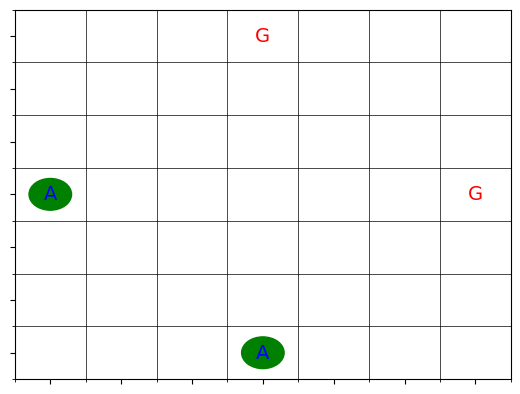

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def visualize(grid, paths):
    # Initialize figure and axis
    fig, ax = plt.subplots()
    ax.set_xticks(range(grid.shape[1]))
    ax.set_yticks(range(grid.shape[0]))
    ax.set_xticks(np.arange(-0.5, grid.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, grid.shape[0], 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=0.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlim(-0.5, grid.shape[1] - 0.5)
    ax.set_ylim(-0.5, grid.shape[0] - 0.5)

    # Define a set of colors for agents
    colors = plt.cm.get_cmap("tab10", len(paths))

    # Mark initial positions and goals
    for idx, (agent, path) in enumerate(paths.items()):
        start = path[0][0]  # Unpack Position object for start
        goal = path[-1][0]  # Unpack Position object for goal
        color = colors(idx)
        ax.text(start.y, start.x, 'A', color=color, ha='center', va='center', fontsize=14)
        ax.text(goal.y, goal.x, 'G', color=color, ha='center', va='center', fontsize=14)

    # Create the animation
    frames = max(len(path) for path in paths.values())
    patches = []

    for idx, path in enumerate(paths.values()):
        pos, _ = path[0]  # Unpack first Position object and time
        color = colors(idx)
        patch = plt.Circle((pos.y, pos.x), 0.3, color=color, animated=True)
        ax.add_patch(patch)
        patches.append((patch, path))

    def update(frame):
        for patch, path in patches:
            if frame < len(path):
                pos, _ = path[frame]  # Unpack Position object and time
                patch.center = (pos.y, pos.x)
        return [patch for patch, _ in patches]

    ani = animation.FuncAnimation(fig, update, frames=frames, blit=True, interval=500, repeat=False)
    plt.show()
# Visualize the paths
if paths:
    visualize(grid, paths)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

def create_grid(grid_size, reservations, paths):
    """
    Create an initial grid visualization showing reservations and agent paths.
    """
    grid = np.zeros(grid_size)

    for (x, y, t), agent_id in reservations.items():
        grid[x, y] = -1  # Reserved cells

    return grid

def update_grid(grid, reservations, paths, current_time):
    """
    Update the grid visualization with the current positions of agents.
    """
    grid[:] = 0  # Reset grid

    # Update with reservations
    for (x, y, t), agent_id in reservations.items():
        if t == current_time:
            grid[x, y] = -1

    # Update with agent positions from paths
    for agent_id, path in paths.items():
        for pos, t in path:
            if t == current_time:
                grid[pos.x, pos.y] = agent_id + 1

    return grid

def visualize_paths(grid, reservations, paths, time_steps):
    """
    Visualize the grid updates over time.
    """
    fig, ax = plt.subplots()
    cmap = plt.cm.get_cmap("viridis", len(paths) + 2)  # Custom colormap
    ax.set_xticks(range(len(grid)))
    ax.set_yticks(range(len(grid[0])))
    ax.set_xticks(np.arange(-0.5, len(grid[0]), 1), minor=True)
    ax.set_yticks(np.arange(-0.5, len(grid), 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=0.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Initialize grid
    def update(frame):
        current_grid = update_grid(grid.copy(), reservations, paths, frame)
        ax.clear()
        ax.imshow(current_grid, cmap=cmap, vmin=-1, vmax=len(paths) + 1)
        ax.set_title(f"Time step: {frame}")
        ax.grid(which="minor", color="black", linestyle='-', linewidth=0.5)
        ax.set_xticks(np.arange(-0.5, len(grid[0]), 1), minor=True)
        ax.set_yticks(np.arange(-0.5, len(grid), 1), minor=True)
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    ani = FuncAnimation(fig, update, frames=range(time_steps), interval=500, repeat=False)
    plt.show()

# Example usage (simple test):
if __name__ == "__main__":
    # Grid: 0 = free, 1 = obstacle
    grid = np.zeros([7,7])

    # Simulate paths and reservations (as output from cooperative_astar)
    test_reservations = {(0, 0, 0): 0, (1, 0, 1): 0}
# Find paths
    paths = cooperative_astar(agents, grid)

    # Visualize
    visualize_paths(grid, test_reservations, paths,)
